# **----- Import Libraries -----**

In [37]:
import pandas as pd

# import libraries for saving the model, vectorizer, scaler
import pickle, json

# import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import train test split
from sklearn.model_selection import train_test_split

# import the vectorizers, scaler, smote
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# import the model including logistic regression, decision tree, bagged decision tree, random forest, ada boost, gradient boost, xgboost, svm 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# import the metrics including accuracy score, precision score, recall score, f1 score, roc auc score, confusion matrix as well as classification report, roc curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve

# confusion matrix
from sklearn.metrics import confusion_matrix



# **----- Import Data -----**

In [38]:
#import the file "df_pantip_posts_suicide_labeled_processed.csv" from output folder
df_pantip_posts_suicide_labeled_processed = pd.read_csv('../output - final/df_pantip_posts_suicide_labeled_processed.csv')

# **----- Define X,y and Do Train-test Split -----**

In [39]:
# check column and data type of the dataframe df_pantip_posts_suicide_labeled_processed
print(df_pantip_posts_suicide_labeled_processed.shape)
print(df_pantip_posts_suicide_labeled_processed.columns)
print(df_pantip_posts_suicide_labeled_processed['label'].value_counts())
print(df_pantip_posts_suicide_labeled_processed['sub_label'].value_counts())



(23834, 21)
Index(['Unnamed: 0', 'index', 'title', 'url', 'label', 'tags', 'text',
       'profile', 'time', 'sub_label', 'all_text', 'tokenized_text',
       'day_week', 'day_month', 'month_year', 'year', 'time_day', 'title_len',
       'text_len', 'title_emoji', 'text_emoji'],
      dtype='object')
label
0    22573
1     1261
Name: count, dtype: int64
sub_label
0     22573
11      779
12      482
Name: count, dtype: int64


In [40]:
# check NaN
df_pantip_posts_suicide_labeled_processed.isnull().sum()

Unnamed: 0        0
index             0
title             0
url               0
label             0
tags              0
text              0
profile           0
time              0
sub_label         0
all_text          0
tokenized_text    0
day_week          0
day_month         0
month_year        0
year              0
time_day          0
title_len         0
text_len          0
title_emoji       0
text_emoji        0
dtype: int64

In [41]:
# define X including time category feature, text numeric feature, text category features, tags, and tokenized text, and define y which is column 'label
# also drop the columns that are not available in youtube data later to make model for generalizable across platform
y = df_pantip_posts_suicide_labeled_processed['label']
X = df_pantip_posts_suicide_labeled_processed.drop(columns=['Unnamed: 0', 'title_len', 'title_emoji', 'tags', 'index', 'title', 'url', 'label', 'text','all_text',
       'profile', 'time', 'sub_label'])
print(X.columns)

Index(['tokenized_text', 'day_week', 'day_month', 'month_year', 'year',
       'time_day', 'text_len', 'text_emoji'],
      dtype='object')


In [42]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify=y)

# **----- Feature Engineering -----**

In [43]:
#Step 1: One-Hot Encoding for Categorical Data

cols = ['day_week', 'day_month', 'month_year', 'year', 'time_day', 'text_emoji']
X_train_categorical = pd.get_dummies(X_train[cols], columns=cols, drop_first=True, dtype=int)
X_test_categorical = pd.get_dummies(X_test[cols], columns=cols, drop_first=True, dtype=int)

print(X_train_categorical.columns)
print(type(X_train_categorical))
print(X_train_categorical.shape)

Index(['day_week_Monday', 'day_week_Saturday', 'day_week_Sunday',
       'day_week_Thursday', 'day_week_Tuesday', 'day_week_Wednesday',
       'day_month_2', 'day_month_3', 'day_month_4', 'day_month_5',
       'day_month_6', 'day_month_7', 'day_month_8', 'day_month_9',
       'day_month_10', 'day_month_11', 'day_month_12', 'day_month_13',
       'day_month_14', 'day_month_15', 'day_month_16', 'day_month_17',
       'day_month_18', 'day_month_19', 'day_month_20', 'day_month_21',
       'day_month_22', 'day_month_23', 'day_month_24', 'day_month_25',
       'day_month_26', 'day_month_27', 'day_month_28', 'day_month_29',
       'day_month_30', 'day_month_31', 'month_year_August',
       'month_year_December', 'month_year_February', 'month_year_January',
       'month_year_July', 'month_year_June', 'month_year_March',
       'month_year_May', 'month_year_November', 'month_year_October',
       'month_year_September', 'year_2017', 'year_2018', 'year_2019',
       'year_2020', 'year_2021', 'y

In [44]:
#Step 2: Vectorization of 'tokenized_text'

vectorizer = TfidfVectorizer()
X_train_text = vectorizer.fit_transform(X_train['tokenized_text'])
X_test_text = vectorizer.transform(X_test['tokenized_text'])

print(type(X_train_text))
print(X_train_text.shape)

print(type(X_test_text))
print(X_test_text.shape)

<class 'scipy.sparse._csr.csr_matrix'>
(19067, 17505)
<class 'scipy.sparse._csr.csr_matrix'>
(4767, 17505)


In [45]:
# Step 3: Scaling of Numerical Data

scaler = StandardScaler()
X_train_numerical = scaler.fit_transform(X_train[['text_len']])
X_test_numerical = scaler.transform(X_test[['text_len']])

print(type(X_train_numerical))
X_train_numerical.shape

<class 'numpy.ndarray'>


(19067, 1)

In [46]:
# Step 4: Concatenate All Features for Training Data

X_train_all = pd.concat([
    pd.DataFrame(X_train_numerical, columns=['text_len'], index=X_train.index),
    pd.DataFrame(X_train_text.todense(), columns=vectorizer.get_feature_names_out(), index=X_train.index),
    X_train_categorical
], axis=1)

print(X_train_all.shape)


(19067, 17568)


In [47]:
# Step 4: Concatenate All Features for Test Data
X_test_all = pd.concat([
    pd.DataFrame(X_test_numerical, columns=['text_len'], index=X_test.index),
    pd.DataFrame(X_test_text.todense(), columns=vectorizer.get_feature_names_out(), index=X_test.index),
    X_test_categorical
], axis=1)

print(X_test_all.shape)

(4767, 17568)


In [48]:
# Step 5: smote X_train and y_train
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_all, y_train)

print(X_train_sm.shape)


(36116, 17568)


In [49]:
# Step 6: Checking and Renaming Duplicate Features

# Function to rename duplicate columns by adding a suffix
def rename_duplicates(df):
    cols = pd.Series(df.columns)
    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
    df.columns = cols
    return df

# Apply it to your training data
rename_duplicates(X_train_sm)

# If you're transforming your test data similarly, apply it there too
rename_duplicates(X_test_all)

# check the shape of X_train_sm and X_test_all
print(X_train_sm.shape)
print(X_test_all.shape)

(36116, 17568)
(4767, 17568)


In [50]:
X_train_sm.columns.isna().sum()

0

In [51]:
# Save X_train_sm column to the list of X_train_sm columns so we can use this list to match with X_sm of youtube data and use the same model to predict
X_train_sm_columns = X_train_sm.columns.tolist()

with open('../model/X_train_sm_label_columns.json', 'w') as f:
    json.dump(X_train_sm_columns, f)

# **----- Do the  modeling & evaluating -----**

## Logistic Regression Modeling & Coefficient Analysis

In [52]:
#Run Logistic Regression Model to test compute time
lr = LogisticRegression(random_state=42, class_weight={0:1, 1:10})
lr.fit(X_train_sm, y_train_sm)
y_pred_lr = lr.predict(X_test_all)
y_pred_lr_proba = lr.predict_proba(X_test_all)[:,1]


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [55]:
# Set threshold for Logistic Regression

def get_pred_by_proba(proba, threshold=0.5):
    return [1 if p >= threshold else 0 for p in proba]


y_pred_lr = get_pred_by_proba(y_pred_lr_proba, threshold=0.1)

In [56]:
#evaluate the model both test and train model comparison for Logistic Regression
print('Logistic Regression')
print('Accuracy score: ', accuracy_score(y_test, y_pred_lr))
print('Precision score: ', precision_score(y_test, y_pred_lr))
print('Recall score: ', recall_score(y_test, y_pred_lr))
print('F1 score: ', f1_score(y_test, y_pred_lr))
print('ROC AUC score: ', roc_auc_score(y_test, y_pred_lr))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred_lr))
print('Classification Report: \n', classification_report(y_test, y_pred_lr))


Logistic Regression
Accuracy score:  0.6920495070274806
Precision score:  0.13636363636363635
Recall score:  0.9047619047619048
F1 score:  0.237006237006237
ROC AUC score:  0.792469545957918
Confusion Matrix: 
 [[3071 1444]
 [  24  228]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.68      0.81      4515
           1       0.14      0.90      0.24       252

    accuracy                           0.69      4767
   macro avg       0.56      0.79      0.52      4767
weighted avg       0.95      0.69      0.78      4767



In [57]:
# save classification report to csv file
report = classification_report(y_test, y_pred_lr, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv('../result/pantip_model_simplifeid_label_lr_classification_report.csv', index=False)


In [58]:
# save model to pickle file
pickle.dump(lr, open('../model/pantip_post_model_train_simplified_label_lr.pkl', 'wb'))

# save vectorizer to pickle file
pickle.dump(vectorizer, open('../model/pantip_post_model_train_simplified_label_vectorizer.pkl', 'wb'))

# save scaler to pickle file
pickle.dump(scaler, open('../model/pantip_post_model_train_simplified_label_scaler.pkl', 'wb'))


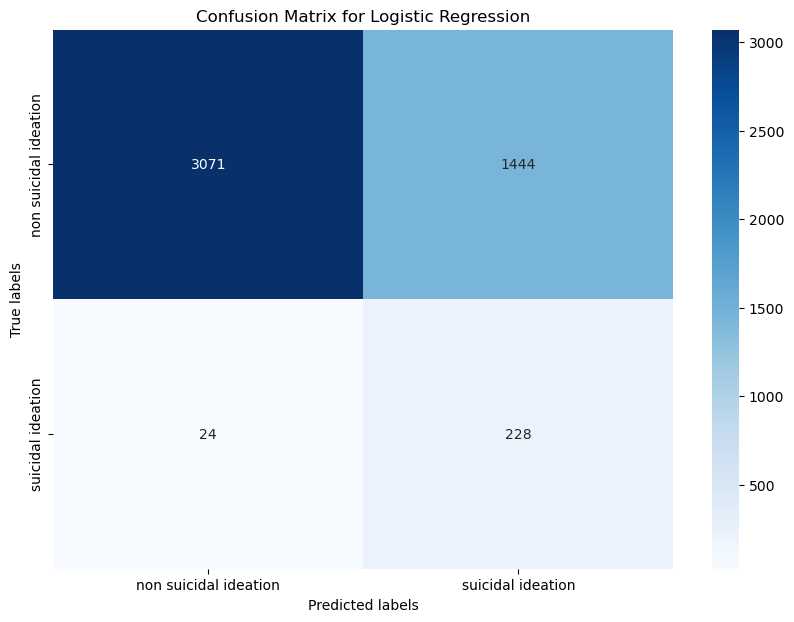

In [60]:
# use the confusion matrix display function from library to display the confusion matrix chart for Logistic Regression; assuming label 1 is suicidal ideation and 0 is non suicidal ideation
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([0.5, 1.5], ['non suicidal ideation', 'suicidal ideation'])
plt.yticks([0.5, 1.5], ['non suicidal ideation', 'suicidal ideation'])
plt.savefig('../result/pantip_model_simplified_label_lr_confusion_matrix.png')
plt.show()



In [54]:
# create the coefficients dataframe and sorting the values from highest to lowest
coef_df = pd.DataFrame(lr.coef_.T, index=X_train_sm.columns, columns=['coef'])
coef_df['coef_abs'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values(by='coef_abs', ascending=False)           
coef_df.head(20)


,coef,coef_abs
ดส,7.220902,7.220902
จบช,5.958802,5.958802
การตาย,5.935402,5.935402
ความค,5.821617,5.821617
นใจ,-5.727121,5.727121
หาย,5.717911,5.717911
ทรมาน,5.716305,5.716305
ความตาย,5.053404,5.053404
บม,-5.005159,5.005159
บาป,4.914452,4.914452


## Decision Tree Modeling 

In [61]:
# Run Decision Tree Model to test compute time
dt = DecisionTreeClassifier(random_state=42, class_weight={0:1, 1:3})
dt.fit(X_train_sm, y_train_sm)
y_pred_dt = dt.predict(X_test_all)
y_pred_dt_proba = dt.predict_proba(X_test_all)[:,1]


In [62]:
# Set threshold for Decision Tree

def get_pred_by_proba(proba, threshold=0.5):
    return [1 if p >= threshold else 0 for p in proba]

y_pred_dt = get_pred_by_proba(y_pred_dt_proba, threshold=0.1)

In [63]:
# evaluate the model both test and train model comparison for Decision Tree

print('Decision Tree')
print('Accuracy score: ', accuracy_score(y_test, y_pred_dt))
print('Precision score: ', precision_score(y_test, y_pred_dt))
print('Recall score: ', recall_score(y_test, y_pred_dt))
print('F1 score: ', f1_score(y_test, y_pred_dt))
print('ROC AUC score: ', roc_auc_score(y_test, y_pred_dt))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred_dt))
print('Classification Report: \n', classification_report(y_test, y_pred_dt))


Decision Tree
Accuracy score:  0.9026641493601846
Precision score:  0.2534883720930233
Recall score:  0.43253968253968256
F1 score:  0.3196480938416423
ROC AUC score:  0.6807216685123662
Confusion Matrix: 
 [[4194  321]
 [ 143  109]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.93      0.95      4515
           1       0.25      0.43      0.32       252

    accuracy                           0.90      4767
   macro avg       0.61      0.68      0.63      4767
weighted avg       0.93      0.90      0.91      4767



In [64]:
# save classification report to csv file
report = classification_report(y_test, y_pred_dt, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv('../result/pantip_model_simplifeid_label_dt_classification_report.csv', index=False)

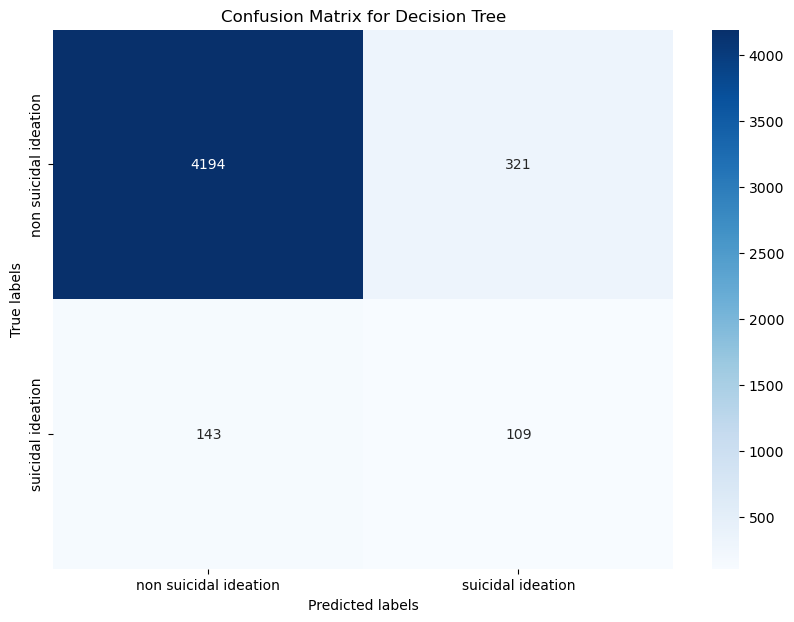

In [65]:
# use the confusion matrix display function from library to display the confusion matrix chart for Logistic Regression; assuming label 1 is suicidal ideation and 0 is non suicidal ideation
cm = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Decision Tree')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([0.5, 1.5], ['non suicidal ideation', 'suicidal ideation'])
plt.yticks([0.5, 1.5], ['non suicidal ideation', 'suicidal ideation'])
plt.savefig('../result/pantip_model_simplified_label_dt_confusion_matrix.png')
plt.show()